**Imports**

In [1]:
import numpy as np
from scipy import signal
from scipy.linalg import solve_continuous_are, solve_discrete_are
import matplotlib.pyplot as plt

**Constants**

In [2]:
# Moment of Inertia (CONSTANT)
# assuming weight = 40lbs = 18.14kg, L = 0.6m, W=0.3m
I = 0.68

# Motor Torque Const (CONSTANT)
# calculated Kt = 0.225 Nm/A using holding torque = 0.18Nm, rated current = 0.8A.
# since u is voltage, Ku = 0.225 / R = 0.225 / 6.8 = 0.03309 Nm/V
Ku = 0.03309

# Viscous Friction Coefficient (CONSTANT)
# this is a broad assumption, should be tweaked if possible
b = 0.2

**State Space Matrices**

In [3]:
# STATE SPACE MATRICES
# x[0] = theta (rad) (angle), x[1] = omega (rad/s) (angular velocity)
#   (x[0])' = x[1] 
#   (x[1])' = -(b/I)*x[1] + (Ku/I)*u
A = np.array([[0.0, 1.0],
              [0.0, -b / I]])

B = np.array([[0.0],
              [Ku / I]])

C = np.array([[1.0, 0.0]])
D = np.array([[0.0]])

# LQR weights (the higher the number, the more you care)
Q = np.diag([200.0, 20.0])   # penalize angle strongly, care less abt vel
R = np.array([[40.0]]) # weights for u (penalizes control effort)

**Continuous & Discrete LQR Calculations**

In [4]:
# Continuous LQR (Kc) is computed assuming continuous-time system dynamics (A, B).
# Discrete LQR (Kd) is computed after discretizing the system with sampling time Ts.
# Kd is used for the simulation because we are implementing a digital controller
# that updates at discrete time intervals.

# Continuous LQR
P = solve_continuous_are(A, B, Q, R) # Solves the continuous-time algebraic Riccati equation
Kc = np.linalg.inv(R) @ B.T @ P # compute optimal feedback
print("Continuous LQR Kc:", Kc.flatten())

# Discretize LQR
Ts = 0.02 # sampling rate
Ad, Bd, Cd, Dd, _ = signal.cont2discrete((A, B, C, D), Ts)
Pd = solve_discrete_are(Ad, Bd, Q, R)
Kd = np.linalg.inv(Bd.T @ Pd @ Bd + R) @ (Bd.T @ Pd @ Ad)
print("Discrete LQR Kd:", Kd.flatten())

Continuous LQR Kc: [2.23606798 5.31078316]
Discrete LQR Kd: [2.23029673 5.30379131]


**Running the Simulation**

In [5]:
# Simulate closed-loop tracking a 0.5 rad step
Tsim = 15.0
t = np.arange(0, Tsim, Ts)

# x[0] = theta (rad) (angle), x[1] = omega (rad/s) (angular velocity)
x = np.array([[0.0], [0.0]]) 

# THIS IS ESSENTIALLY HOW MISPLACED NACELLE IS (0 <= theta_ref <= 2pi)
theta_ref = 0.5

th = [] # misplacement of theta overtime
uh = [] # motor usage (u) overtime

# Notes on control input u, in the simulation loop:
#   u is normalized between -1 and 1 and represents the motor voltage.
#   Actual voltage: V_motor = u * V_max
#   np.clip(u, -1, 1) models motor saturation, ensuring the applied voltage never exceeds the motor's physical limits.
#   negative u => reverse direction
for _ in t:
    th.append(x[0, 0])
    x_ref = np.array([[theta_ref], [0.0]])
    u = -Kd @ (x - x_ref)
    u = np.clip(u, -1.0, 1.0)  # limit control input
    uh.append(float(np.squeeze(u)))
    x = Ad @ x + Bd @ u

**Theta Vs. Reference**

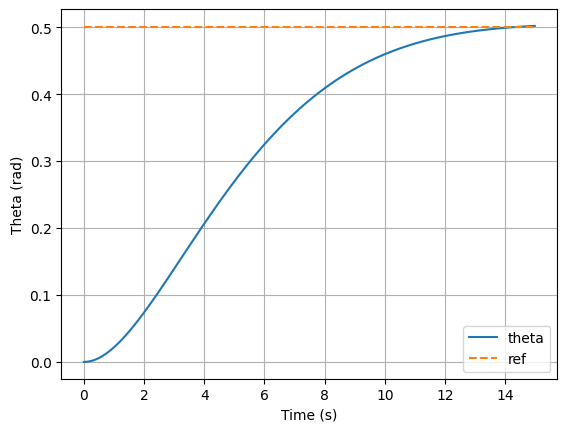

In [6]:
# Plot theta vs reference
# dashed line => target angle
# solid line => actual angular posn
plt.figure()
plt.plot(t, th, label='theta')
plt.plot(t, np.ones_like(t) * theta_ref, '--', label='ref')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.grid(True)
plt.legend()

**Control Input**

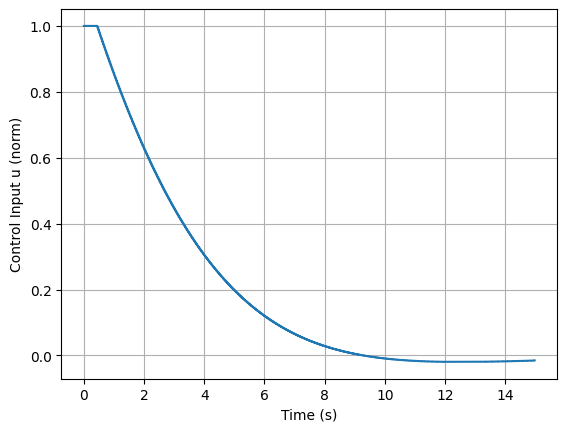

In [7]:
# Plot control input
# voltage command sent by the controller, normalized between [-1, 1], at each time stip
plt.figure()
plt.step(t, uh, where='post')
plt.xlabel('Time (s)')
plt.ylabel('Control Input u (norm)')
plt.grid(True)

plt.show()
